In this lab we will learn, how vector representations of different objects can be obtained, and how they can be utilized for recommendations and search.

# 1. [40] If there's no asparagus in Innopolis...

When you find something that you like - whether it is a poem, song, or image, it's often useful to have an option to find similar items, such that you can enjoy songs of the same kind, for example. For this there exist **recommender systems**, and we will build one today. Given a dataset on nutrition of some products, you will be able to search for similar ones, e.g. for replacement in your daily meal: what if you don't have good asparagus in Innopolis?

The recommender system will be based on the vector-space model + dimensionality reduction + cosine similarity measure.

In [89]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

## 1.1. Reading the dataset

Next block reads the data from a CSV dataset: https://raw.githubusercontent.com/IUCVLab/information-retrieval/main/datasets/nutrition.csv

You can also see this data on GitHub as a beatuful table https://github.com/IUCVLab/information-retrieval/blob/main/datasets/nutrition.csv

In [90]:
# you will need internet connection for this block
csv_url = "https://raw.githubusercontent.com/IUCVLab/information-retrieval/main/datasets/nutrition.csv"
dataset = pd.read_csv(csv_url)

# there are no (0) saturated fats in vegetables, that's why we replace N/A values with 0
dataset = dataset.fillna(0)

classes_list = dataset["Food Type"][1:].values
names = dataset["Food and Serving"][1:].values
names = [name.split(',')[0] for name in names]

dimensions = dataset.columns[1:]

print("Names:", *names[:5], "...", sep=" | ")
print()
print("Classes:", *set(classes_list), sep=" | ")
print()
print("Dimensions:", *dimensions[:5], "...", sep=" | ")

dataset.head()

Names: | Asparagus | Bell Pepper | Broccoli | Carrot | Cauliflower | ...

Classes: | Vegetables, Serving Size (gram weight/ ounce weight) | Seafood, Serving Size (84 g/3 oz) | Fruits Serving Size (gram weight/ounce weight)

Dimensions: | Calories | Calories from Fat | Total Fat 1 | Total Fat 2 | Sodium 1 | ...


,Food and Serving,Calories,Calories from Fat,Total Fat 1,Total Fat 2,Sodium 1,Sodium 2,Potassium 1,Potassium 2,Total Carbo-hydrate 1,...,Protein,Vitamin A,Vitamin C,Calcium,Iron,Saturated Fat,Saturated Fat 2,Chole-sterol 1,Chole-sterol 2,Food Type
0,0,0.0,0.0,(g),(%DV),(g),(%DV),(g),(%DV),(g),...,(g),(%DV),(%DV),(%DV),(%DV),(%DV),(mg),(%DV),(mg),0
1,"Asparagus, 5 spears (93 g/3.3 oz)",20.0,0.0,0,0,0,0,230,7,4,...,2,10,15,2,2,0,0,0,0,"Vegetables, Serving Size (gram weight/ ounce w..."
2,"Bell Pepper, 1 medium (148 g/5.3 oz)",25.0,0.0,0,0,40,2,220,6,6,...,1,4,190,2,4,0,0,0,0,"Vegetables, Serving Size (gram weight/ ounce w..."
3,"Broccoli, 1 medium stalk (148 g/5.3 oz)",45.0,0.0,0.5,1,80,3,460,13,8,...,4,6,220,6,6,0,0,0,0,"Vegetables, Serving Size (gram weight/ ounce w..."
4,"Carrot, 1 carrot, 7"" long, 1 1/4"" diameter (78...",30.0,0.0,0,0,60,3,250,7,7,...,1,110,10,2,2,0,0,0,0,"Vegetables, Serving Size (gram weight/ ounce w..."


## 1.2. Assigning colors each food item
Building a `color_list` which attributes a color to each item.

In [91]:
classes = list(set(classes_list))
colors = ["red", "green", "blue", "black", "magenta"]
class_colors = {}
for i in range(len(classes)):
    class_colors[classes[i]] = colors[i % len(colors)]
    
print(class_colors)
color_list = [class_colors[a] for a in classes_list]

{'Vegetables, Serving Size (gram weight/ ounce weight)': 'red', 'Seafood, Serving Size (84 g/3 oz)': 'green', 'Fruits Serving Size (gram weight/ounce weight)': 'blue'}


## 1.3. Plotting functions

We will use these functions to visualize data in 2D and 3D.

In [92]:
def show_points_2d(X, Y, xaxis, yaxis):
    global names, classes_list, class_colors
    plt.figure(figsize=(12,8))
    plt.xlabel(xaxis)
    plt.ylabel(yaxis)
    classes = set()
    for x, y, name, label in zip(X, Y, names, classes_list):
        if not label in classes:
            plt.plot([x], [y], "o", markersize=20, color=class_colors[label], label=label)
            classes.add(label)
        else:
            plt.plot([x], [y], "o", markersize=20, color=class_colors[label])
        plt.text(x, y, name)
    plt.legend()
    plt.axvline(0)
    plt.axhline(0)
    plt.show()
    
def show_points_3d(X, Y, Z):
    global color_list
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    for x, y, z, color in zip(X, Y, Z, color_list):
        ax.scatter([x], [y], [z], marker='o', color=color)
    plt.show()
    
def show_matrix(A, xaxis, yaxis):
    plt.figure(figsize=(15,10))
    plt.xlabel(xaxis)
    plt.ylabel(yaxis)
    plt.imshow(A)
    plt.show()    

## 1.4. Data Visualization
Matrix `A` will hold numerical data from dataset. It has (61 items)x(22 features) size. In "real" tasks this could be (1B users)x(300 features). In such case each additional feature would cost 8GB of storage. It can be a good idea to cut redundant dimensions.

Raw values, columns are objects (61, 22)


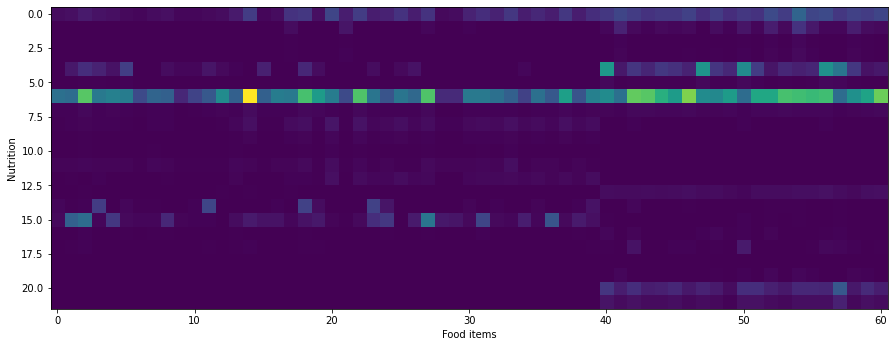

2 random dimensions distribution


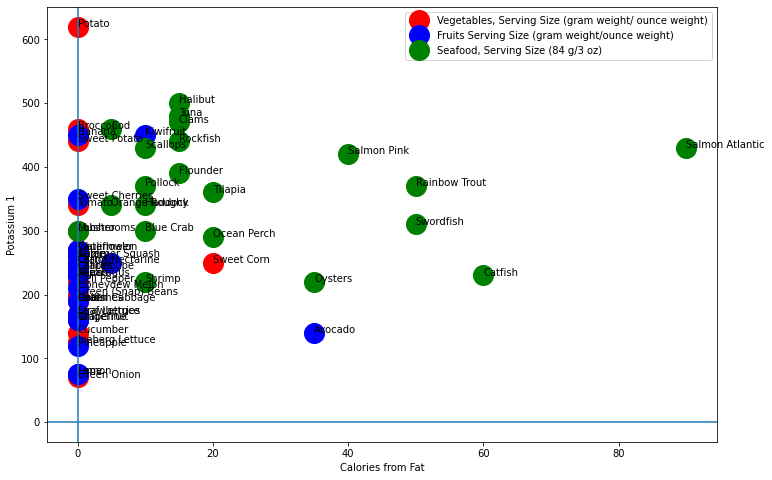

In [93]:
A = np.array(dataset.values[1:,1:-1].astype(float))
print("Raw values, columns are objects", A.shape)
show_matrix(A.T, "Food items", "Nutrition")

print("2 random dimensions distribution")
show_points_2d(A.T[1], A.T[6], dimensions[1], dimensions[6])

## 1.5. [10] Dimensionality reduction with Principal Components Analysis
Principal components are the dimensions, which express **dataset diversity** in the best way: the **variance** is maximized along these dimensions. Thus, we can keep only most valuable ones if we are sure they distiguish our data well. Let's keep 3 principal components. **Fill in the code to apply PCA to our data**.

In [94]:
from sklearn.decomposition import PCA
k = 3
pca = PCA(n_components=k)
#TODO apply PCA to matrix A, and save the results to A_pca
A_pca = pca.fit_transform(A)

In [95]:
assert A_pca.shape == (61, 3)

Check how much variance is explained by the first `k` components. Refer to [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html).

In [96]:
# TODO compute the value
explainted_variance_ratio =  np.sum(pca.explained_variance_ratio_)

In [97]:
assert explainted_variance_ratio > 0.9, "Something went wrong with PCA"

Now, let's **visualize** the data after transformation applied.

2 first dimensions


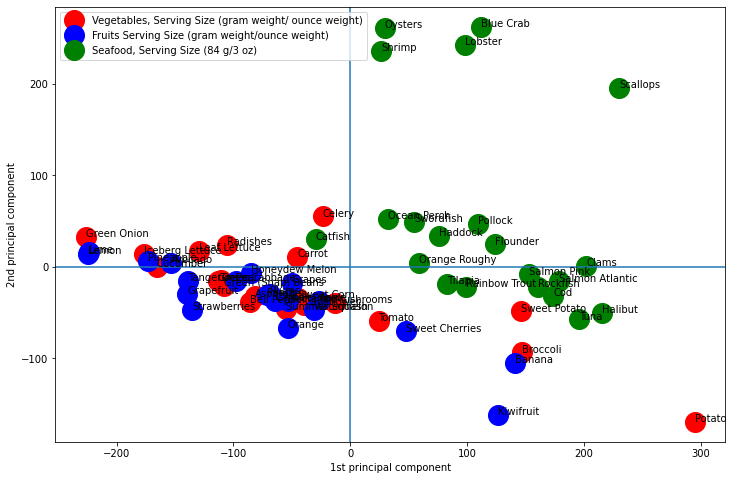

3 first dimensions


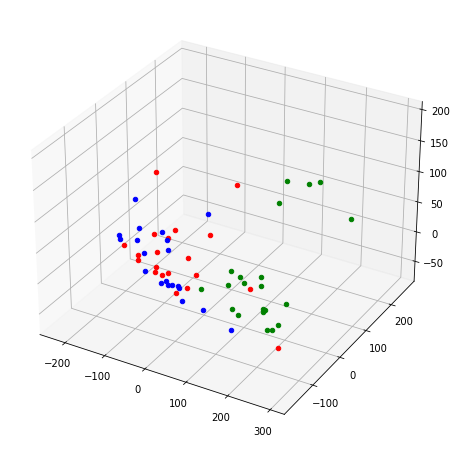

In [98]:
print("2 first dimensions")
show_points_2d(A_pca.T[0], A_pca.T[1], "1st principal component", "2nd principal component")
print("3 first dimensions")
show_points_3d(A_pca.T[0], A_pca.T[1], A_pca.T[2])

## 1.5. [10] Dimensionality reduction with SVD

SVD is not appying centering at the first stage. Instead of variance, it preserves cosine similaity measure, which is more interesting in our case.

In [99]:
from numpy.linalg import svd
k = 3

#TODO apply SVD to matrix A, and save the results to A_svd
U, sigma, V = np.linalg.svd(A, full_matrices=True)# ..

U_ =  U[:,:k]#...
S_ =  np.diag(sigma)[:k,:k]#...
V_ =  V[:k,:]#...

A_svd = U_ @ S_


In [100]:
assert A_svd.shape == (61, 3)

How it looks like?

2 first dimensions


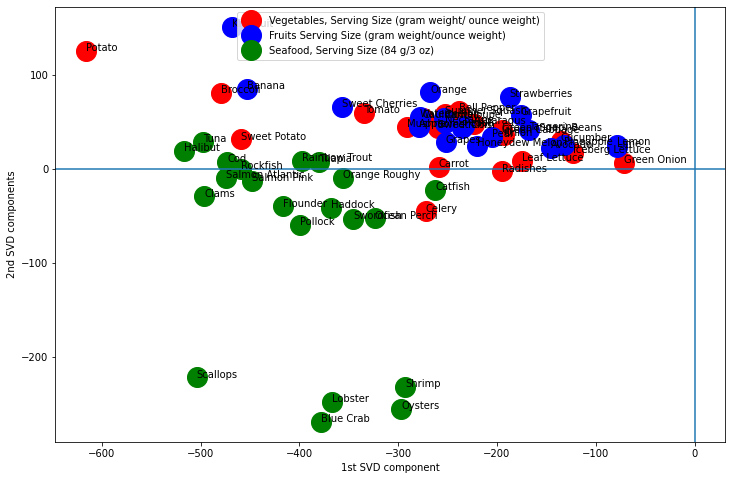

3 first dimensions


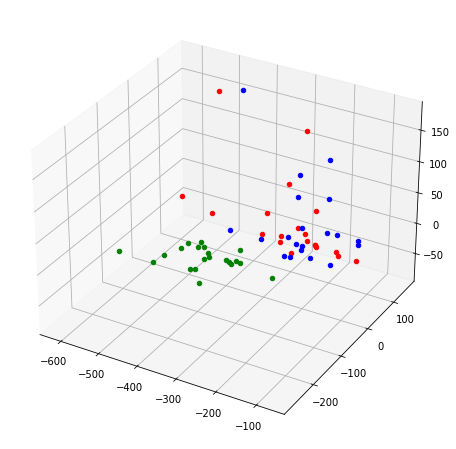

In [101]:
print("2 first dimensions")
show_points_2d(A_svd.T[0], A_svd.T[1], "1st SVD component", "2nd SVD components")
print("3 first dimensions")
show_points_3d(A_svd.T[0], A_svd.T[1], A_svd.T[2])

## 1.6. [10] Norming
It can happen, that some food is more "watered" than the others. See, how different are celery and popatos in terms of calories. Thus, the norm of each item in dataset can be different, and we cannot easily use $L_2$ distance to estimate the difference. But what we can use - [*cosine similarity*](https://en.wikipedia.org/wiki/Cosine_similarity). Cosine similarity shows, how 2 items are "about the same" even if nutrition is of different scale. Look at the formula of cosine similarity: you will find out that if both vectors are **normed**, then $cos(a, b) = a\cdot b$.

**Thus, your task is to norm the dataset vector-wise (row-wise).**

In [102]:
def norm_vectors(A):
    
    #TODO write here a code that will norm each vector (we consider L2 norm here)
    An = A.copy()
    An = An/np.linalg.norm(A.copy(), axis=1).reshape(-1,1)
    return An

How it looks now?

2 first dimensions of PCA


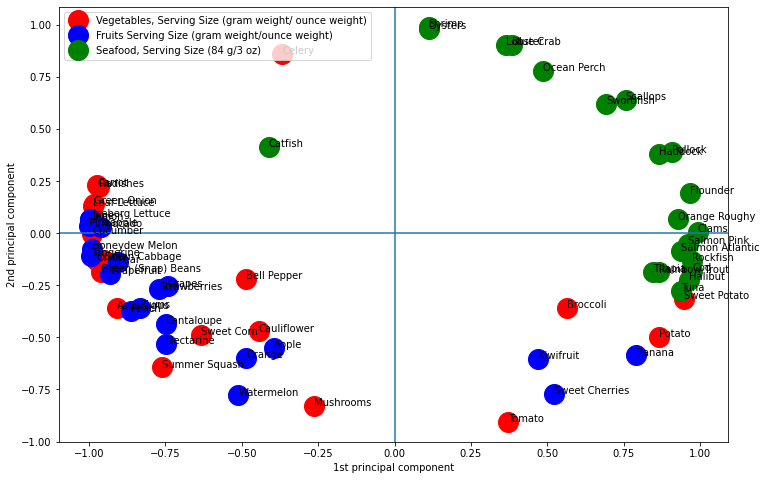

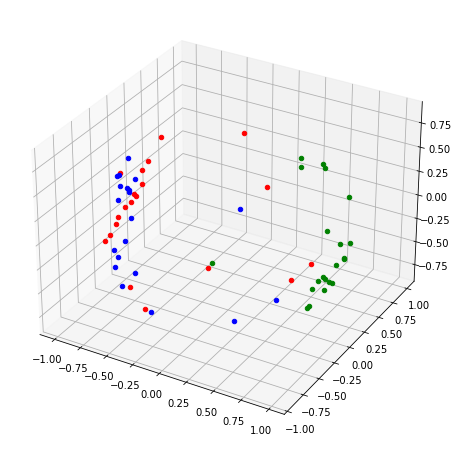

In [103]:
A_pca_norm = norm_vectors(A_pca)

print("2 first dimensions of PCA")
show_points_2d(A_pca_norm.T[0], A_pca_norm.T[1], "1st principal component", "2nd principal component")
show_points_3d(A_pca_norm.T[0], A_pca_norm.T[1], A_pca_norm.T[2])

2 first dimensions of SVD


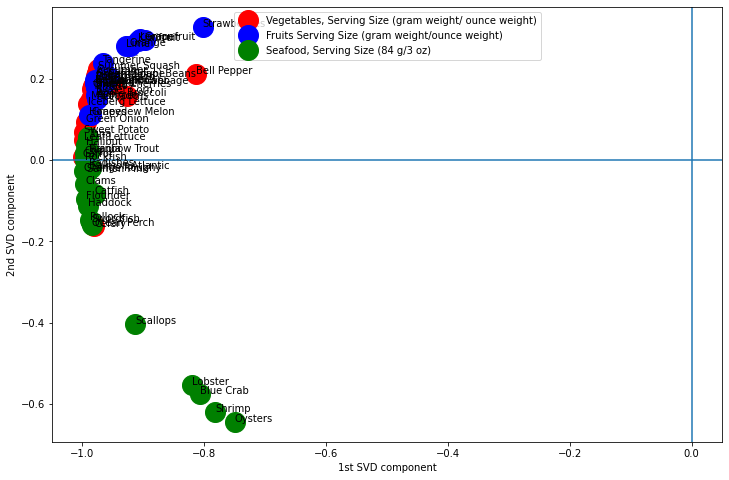

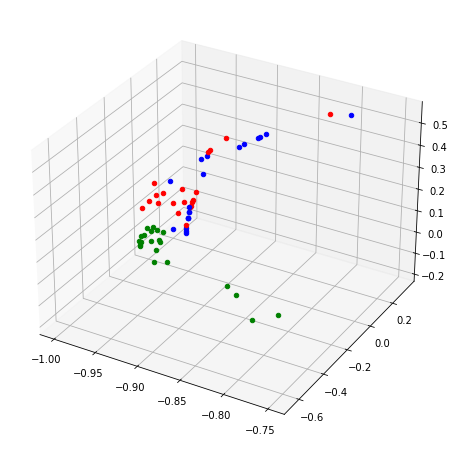

In [108]:
A_svd_norm = norm_vectors(A_svd)

print("2 first dimensions of SVD")
show_points_2d(A_svd_norm.T[0], A_svd_norm.T[1], "1st SVD component", "2nd SVD component")
show_points_3d(A_svd_norm.T[0], A_svd_norm.T[1], A_svd_norm.T[2])

## 1.7. [10] Recommendations
And now the last step left. You represented the data with 3-dimensoinal vectors, instead of 22-dimensional. But we still need the code that will recommend closest food items in terms of nutrition. 

**Please, write the code that will return $k$ closest food items to the provided query vector.**

In [109]:
from sklearn.metrics.pairwise import cosine_similarity

def find_k_closest(query, dataset, k=6):
    #TODO write here the code that will find k closest rows in dataset in terms of cosine similarity
    cosines_raw = cosine_similarity(dataset, query.reshape(1,-1))
    sorted_inds = np.flip(np.argsort(cosines_raw,axis=0))
    return sorted_inds[:k].flatten()

Ok, let's see how your recommendations work :)

In [110]:
import os
from IPython.display import Image

recommend_to = 48
print("For:\t\t", names[recommend_to])
fn = f'../../datasets/nutr_img/{names[recommend_to].lower()}.jpg'
if os.path.exists(fn):
    display(Image(filename=fn))

print("\n\n\n========== Recommending with PCA ==============\n\n\n")

r = find_k_closest(A_pca_norm[recommend_to,:], A_pca_norm)

for k in r:
    if recommend_to != k: # exclude itself 
        print(f"\n\t{names[k]} | similarity = { np.dot(A_pca_norm[k],  A_pca_norm[recommend_to]) :.3}")
        fn = f'../../datasets/nutr_img/{names[k].lower()}.jpg'
        if os.path.exists(fn):
            display(Image(filename=fn))

For:		 Ocean Perch



========== Recommending with PCA ==============




	Swordfish | similarity = 0.966

	Haddock | similarity = 0.845

	Blue Crab | similarity = 0.821

	Scallops | similarity = 0.815

	Shrimp | similarity = 0.808


In [111]:
print("\n\n\n========== Recommending with SVD ==============\n\n\n")
r = find_k_closest(A_svd_norm[recommend_to,:], A_svd_norm)
for k in r:
    fn = f'../../datasets/nutr_img/{names[k].lower()}.jpg'
    if recommend_to != k: # exclude itself 
        print(f"\n\t{names[k]} | similarity = { np.dot(A_svd_norm[k],  A_svd_norm[recommend_to]) :.3}")
        if os.path.exists(fn):
            display(Image(filename=fn))




========== Recommending with SVD ==============




	Swordfish | similarity = 1.0

	Pollock | similarity = 1.0

	Haddock | similarity = 0.999

	Flounder | similarity = 0.998

	Clams | similarity = 0.995


# 2. [60] Evolving vector-space model
This part will be devoted to the use of ML model for the needs of information retrieval and text classification.  

### **Searching in the curious facts database**

The facts dataset is given [here](https://raw.githubusercontent.com/IUCVLab/information-retrieval/main/datasets/facts.txt), take a look. We want you to retrieve facts **relevant to the query** (whatever it means), for example, you type "good mood", and get to know that Cherophobia is the fear of fun. For this, the idea is to utilize document vectors. However, instead of forming vectors with tf-idf and reducing dimensions, this time we want to obtain fixed-size vectors for documents using ML model.

## 2.1. [15] Use neural networks to embed sentences

Make use of any, starting from doc2vec up to Transformers, etc. Provide all code, dependencies, installation requirements.


- [UCE in spacy 2](https://spacy.io/universe/project/spacy-universal-sentence-encoder) (`!pip install spacy-universal-sentence-encoder`)
- [Sentence BERT in spacy 2](https://spacy.io/universe/project/spacy-sentence-bert) (`!pip install spacy-sentence-bert`)
- [Pretrained 🤗 Transformers](https://huggingface.co/transformers/pretrained_models.html)
- [Spacy 3 transformers](https://spacy.io/usage/embeddings-transformers#transformers-installation)
- [doc2vec pretrained](https://github.com/jhlau/doc2vec)
- [Some more sentence transformers](https://www.sbert.net/docs/quickstart.html)

Here should be dependency installation, download instructions and so on. With outputs.

In [112]:
!pip install -U sentence-transformers
from sentence_transformers import SentenceTransformer
nlp = SentenceTransformer('paraphrase-distilroberta-base-v1')

Defaulting to user installation because normal site-packages is not writeable


## 2.2. [10] Write a function that prepares embedding

Write a function, which returns a fixed-sized vector of embedding.

In [113]:
def embed(text):
    #TODO return a fixed-sized vector of embedding
    return nlp.encode(text)

In [114]:
assert len(embed("Some random text")) == len(embed("Folks, here's a story about Minnie the Moocher. She was a lowdown hoochie coocher. She was the roughest, toughest frail, but Minnie had a heart as big as a whale")), "Length should match"

In [115]:
from scipy.spatial.distance import cosine

assert abs(cosine(
            embed("some text for testing"), 
            embed("some text for testing")
        )) < 1e-4, "Embedding should match"

assert abs(cosine(
            embed("Cats eat mice."), 
            embed("Terminator is an autonomous cyborg, typically humanoid, originally conceived as a virtually indestructible soldier, infiltrator, and assassin.")
        )) > 0.2, "Embeddings should be far"

## 2.3. [5] Reading the data

Now, let's read the facts dataset. Download it from the abovementioned url and read to the list of sentences.

In [116]:
import requests
url = "https://raw.githubusercontent.com/IUCVLab/information-retrieval/main/datasets/facts.txt"

#TODO read facts into a list of facts
resp = requests.get(url)
if resp.status_code>=200 and resp.status_code<300:
    with open('facts.txt','wb') as f:
        f.write(resp.content)

facts = []
with open('facts.txt','rb') as f:
    for line in f:
        facts.append(line.decode())


In [117]:
print(*facts[:5], sep='\n')

assert len(facts) == 159
assert ('our lovely little planet') in facts[0]

1. If you somehow found a way to extract all of the gold from the bubbling core of our lovely little planet, you would be able to cover all of the land in a layer of gold up to your knees.

2. McDonalds calls frequent buyers of their food "heavy users."

3. The average person spends 6 months of their lifetime waiting on a red light to turn green.

4. The largest recorded snowflake was in Keogh, MT during year 1887, and was 15 inches wide.

5. You burn more calories sleeping than you do watching television.



## 2.4. [10] Transforming sentences to vectors

Transform the list of facts to `numpy.array` of vectors corresponding to each document (`sent_vecs`), inferring them from the model we just loaded.

In [118]:
#TODO infer vectors
sent_vecs = np.array([embed(sent) for sent in facts])

In [119]:
assert sent_vecs.shape[0] == len(facts)

## 2.5. [10] Find closest

Now find 5 facts which are closest to the query using cosine similarity measure.

In [120]:
#TODO output closest facts to the query
query = "good mood"

print("Results for query:", query)
for k in find_k_closest(embed(query), sent_vecs, 5):
    print("\t", facts[k])

Results for query: good mood
	 57. Gorillas burp when they are happy

	 68. Cherophobia is the fear of fun.

	 44. Honey never spoils.

	 48. Chewing gum burns about 11 calories per hour.

	 29. Chewing gum while you cut an onion will help keep you from crying.



## 2.6. [10] Recommend 5 facts to each of the queries for the following query bucket
```
good mood
gorilla
woman
earth
japan
people
math
```

Recommend 5 facts to each of the queries. Write your code below.

In [121]:
# write your code or computations here
queries = ['good mood', 'gorilla', 'woman', 'earth', 'japan', 'people', 'math']
for query in queries:
    print(query+':')
    for k in find_k_closest(embed(query), sent_vecs, 5):
        print("\t", facts[k])

good mood:
	 57. Gorillas burp when they are happy

	 68. Cherophobia is the fear of fun.

	 44. Honey never spoils.

	 48. Chewing gum burns about 11 calories per hour.

	 29. Chewing gum while you cut an onion will help keep you from crying.

gorilla:
	 55. The word "gorilla" is derived from a Greek word meaning, "A tribe of hairy women."

	 57. Gorillas burp when they are happy

	 125. A ball of glass will bounce higher than a ball of rubber.

	 80. A church in the Czech Republic has a chandelier made entirely of human bones.

	 21. Bolts of lightning can shoot out of an erupting volcano.

woman:
	 55. The word "gorilla" is derived from a Greek word meaning, "A tribe of hairy women."

	 111. Butterflies taste their food with their feet.

	 65. A Swedish woman lost her wedding ring, and found it 16 years later- growing on a carrot in her garden.

	 131. If a pregnant woman has organ damage, the baby in her womb sends stem cells to help repair the organ.

	 3. The average person spend

## 2.7. [BONUS] Write your own relevance assessments and compute DCG@5

In [122]:
#TODO add assesment
assessment = [[2,2,0,1,1],[3,3,0,1,0],[2,0,3,3,1],[3,3,1,2,0],[3,0,3,2,0],[2,0,0,3,3],[0,0,2,0,1]]

def dcg(rels):
    DCG = 0
    for i in range(len(rels)): 
        current_score = (2**(rels[i])-1)
        punishment = (math.log(1+i+1,2))
        DCG += current_score/punishment
    return DCG

sum([dcg(row) for row in assessment]) / len(assessment)

9.009888308667835